# Upload data

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [194]:
# Load the datasets
products_df = pd.read_csv("PRODUCTS_TAKEHOME.csv")
transactions_df = pd.read_csv("TRANSACTION_TAKEHOME.csv")
users_df = pd.read_csv("USER_TAKEHOME.csv")

In [195]:
# Learn about basic information and data types
users_df.info()
products_df.info()
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ID            100000 non-null  object
 1   CREATED_DATE  100000 non-null  object
 2   BIRTH_DATE    96325 non-null   object
 3   STATE         95188 non-null   object
 4   LANGUAGE      69492 non-null   object
 5   GENDER        94108 non-null   object
dtypes: object(6)
memory usage: 4.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845552 entries, 0 to 845551
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CATEGORY_1    845441 non-null  object 
 1   CATEGORY_2    844128 non-null  object 
 2   CATEGORY_3    784986 non-null  object 
 3   CATEGORY_4    67459 non-null   object 
 4   MANUFACTURER  619078 non-null  object 
 5   BRAND         619080 non-null  object 
 6   BARCODE       841527 non-null  float64
d

# Explore the data

## Missing Values

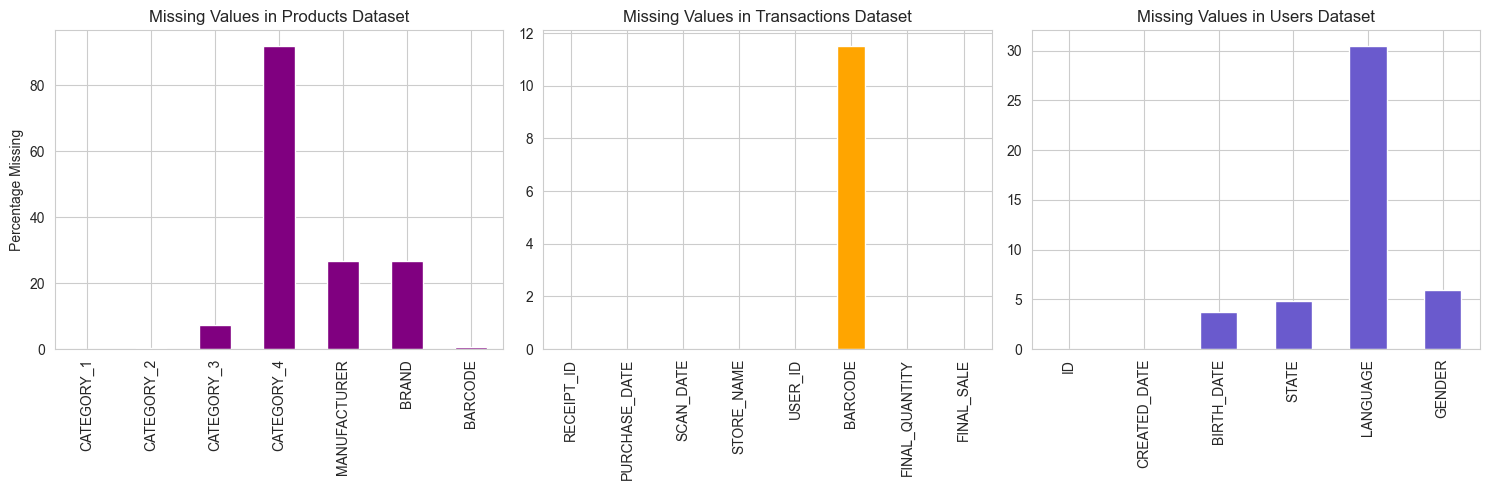

In [196]:
missing_products = products_df.isnull().mean() * 100
missing_transactions = transactions_df.isnull().mean() * 100
missing_users = users_df.isnull().mean() * 100

# Plot missing values as bar charts
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
missing_products.plot(kind='bar', color='purple')
plt.title("Missing Values in Products Dataset")
plt.ylabel("Percentage Missing")

plt.subplot(1, 3, 2)
missing_transactions.plot(kind='bar', color='orange')
plt.title("Missing Values in Transactions Dataset")

plt.subplot(1, 3, 3)
missing_users.plot(kind='bar', color='slateblue')
plt.title("Missing Values in Users Dataset")

plt.tight_layout()
plt.show()


Missing Data Problems
Products Dataset:
CATEGORY_4: ~90% missing → Likely unreliable for analysis.
MANUFACTURER & BRAND: ~30% missing → May affect brand-related insights.
BARCODE: Small % missing → Could impact linking transactions to products.

Transactions Dataset:
BARCODE: 12% missing → Some transactions lack product mapping, affecting sales analysis.

Users Dataset:
LANGUAGE: ~30% missing → Limits user segmentation by language.
BIRTH_DATE & STATE: ~5% missing → Slight impact on demographic insights.
GENDER: ~10% missing → May reduce accuracy in gender-based analysis.


## Duplicate Errors

In [197]:
user_dup = users_df.duplicated().sum(),
trans_dup = transactions_df.duplicated().sum(),
products_dup = products_df.duplicated().sum(),

print("Duplicate Records:")
print("Users: ", user_dup)
print("Transactions: ", trans_dup)
print("Products: ",products_dup)

Duplicate Records:
Users:  (0,)
Transactions:  (171,)
Products:  (215,)



171 duplicate transactions that may distort sales and user behavior insights.
215 duplicate products that can create inconsistencies in product-level reporting.

## Check tables referencing problems

In [198]:
# Transactions without valid Users
nonexist_users = transactions_df.merge(users_df[['ID']], left_on='USER_ID', right_on='ID', how='left')
nonexist_users_count = nonexist_users[nonexist_users['ID'].isnull()].shape[0]

# Transactions without valid Products
nonexist_products = transactions_df.merge(products_df[['BARCODE']], on='BARCODE', how='left', indicator=True)
nonexist_products_count = nonexist_products[nonexist_products['_merge'] == 'left_only'].shape[0]

print("Transactions referencing nonexistent users: ",nonexist_users_count)
print(f"Transactions referencing nonexistent Products: ",nonexist_products_count)


Transactions referencing nonexistent users:  49738
Transactions referencing nonexistent Products:  19408


We do have some date integrity issues here. Nearly 50K transactions reference non-existent users, meaning that we have missing or incorrect user data. 19K transactions reference non-existent products, there are possible barcode mismatches.

## Data Inconsistency

First, I want to check if there are multiple formats of 'STATE' such as CA, Ca, California...

In [199]:
# Standardize text formats
users_df["STATE"] = users_df["STATE"].str.upper().str.strip()
products_df["CATEGORY_1"] = products_df["CATEGORY_1"].str.lower().str.strip()

# Check unique values for inconsistencies
print("Unique States:", users_df["STATE"].unique())
print("Unique Categories:", products_df["CATEGORY_1"].unique())

Unique States: ['CA' 'PA' 'FL' 'NC' 'NY' 'IN' nan 'OH' 'TX' 'NM' 'PR' 'CO' 'AZ' 'RI' 'MO'
 'NJ' 'MA' 'TN' 'LA' 'NH' 'WI' 'IA' 'GA' 'VA' 'DC' 'KY' 'SC' 'MN' 'WV'
 'DE' 'MI' 'IL' 'MS' 'WA' 'KS' 'CT' 'OR' 'UT' 'MD' 'OK' 'NE' 'NV' 'AL'
 'AK' 'AR' 'HI' 'ME' 'ND' 'ID' 'WY' 'MT' 'SD' 'VT']
Unique Categories: ['health & wellness' 'snacks' 'beverages' 'pantry' 'alcohol'
 'apparel & accessories' 'restaurant' 'needs review' 'dairy'
 'home & garden' nan 'household supplies' 'meat & seafood' 'deli & bakery'
 'sporting goods' 'produce' 'office & school' 'frozen'
 'arts & entertainment' 'animals & pet supplies' 'electronics' 'beauty'
 'toys & games' 'mature' 'vehicles & parts' 'baby & toddler'
 'luggage & bags' 'media']


In [200]:
print(users_df.dtypes)
print(transactions_df.dtypes)
print(products_df.dtypes)

ID              object
CREATED_DATE    object
BIRTH_DATE      object
STATE           object
LANGUAGE        object
GENDER          object
dtype: object
RECEIPT_ID         object
PURCHASE_DATE      object
SCAN_DATE          object
STORE_NAME         object
USER_ID            object
BARCODE           float64
FINAL_QUANTITY     object
FINAL_SALE         object
dtype: object
CATEGORY_1       object
CATEGORY_2       object
CATEGORY_3       object
CATEGORY_4       object
MANUFACTURER     object
BRAND            object
BARCODE         float64
dtype: object


Many columns are stored as object (string), even though they should be numeric or datetime. This can cause calculation errors, slow processing, and incorrect filtering.


# Cast data into right types

In order to check data range and outlier problems, cast data into right types first.

In [201]:
# Convert Date Columns
users_df["CREATED_DATE"] = pd.to_datetime(users_df["CREATED_DATE"], errors="coerce")
users_df["BIRTH_DATE"] = pd.to_datetime(users_df["BIRTH_DATE"], errors="coerce")
transactions_df["PURCHASE_DATE"] = pd.to_datetime(transactions_df["PURCHASE_DATE"], errors="coerce")
transactions_df["SCAN_DATE"] = pd.to_datetime(transactions_df["SCAN_DATE"], errors="coerce")

# Convert Numeric Columns
transactions_df["FINAL_QUANTITY"] = pd.to_numeric(transactions_df["FINAL_QUANTITY"], errors="coerce")
transactions_df["FINAL_SALE"] = pd.to_numeric(transactions_df["FINAL_SALE"], errors="coerce")

# Convert Categorical Columns
users_df["STATE"] = users_df["STATE"].astype("str")
users_df["LANGUAGE"] = users_df["LANGUAGE"].astype("str")
users_df["GENDER"] = users_df["GENDER"].astype("str")

products_df["CATEGORY_1"] = products_df["CATEGORY_1"].astype("str")
products_df["CATEGORY_2"] = products_df["CATEGORY_2"].astype("str")
products_df["CATEGORY_3"] = products_df["CATEGORY_3"].astype("str")
products_df["CATEGORY_4"] = products_df["CATEGORY_4"].astype("str")
products_df["MANUFACTURER"] = products_df["MANUFACTURER"].astype("str")
products_df["BRAND"] = products_df["BRAND"].astype("str")

# Auto Convert Other Object Columns
users_df = users_df.convert_dtypes()
transactions_df = transactions_df.convert_dtypes()
products_df = products_df.convert_dtypes()

# Verify Data Types
print(users_df.dtypes)
print(transactions_df.dtypes)
print(products_df.dtypes)


ID                   string[python]
CREATED_DATE    datetime64[ns, UTC]
BIRTH_DATE      datetime64[ns, UTC]
STATE                string[python]
LANGUAGE             string[python]
GENDER               string[python]
dtype: object
RECEIPT_ID             string[python]
PURCHASE_DATE          datetime64[ns]
SCAN_DATE         datetime64[ns, UTC]
STORE_NAME             string[python]
USER_ID                string[python]
BARCODE                         Int64
FINAL_QUANTITY                Float64
FINAL_SALE                    Float64
dtype: object
CATEGORY_1      string[python]
CATEGORY_2      string[python]
CATEGORY_3      string[python]
CATEGORY_4      string[python]
MANUFACTURER    string[python]
BRAND           string[python]
BARCODE                  Int64
dtype: object


## Check for outliers

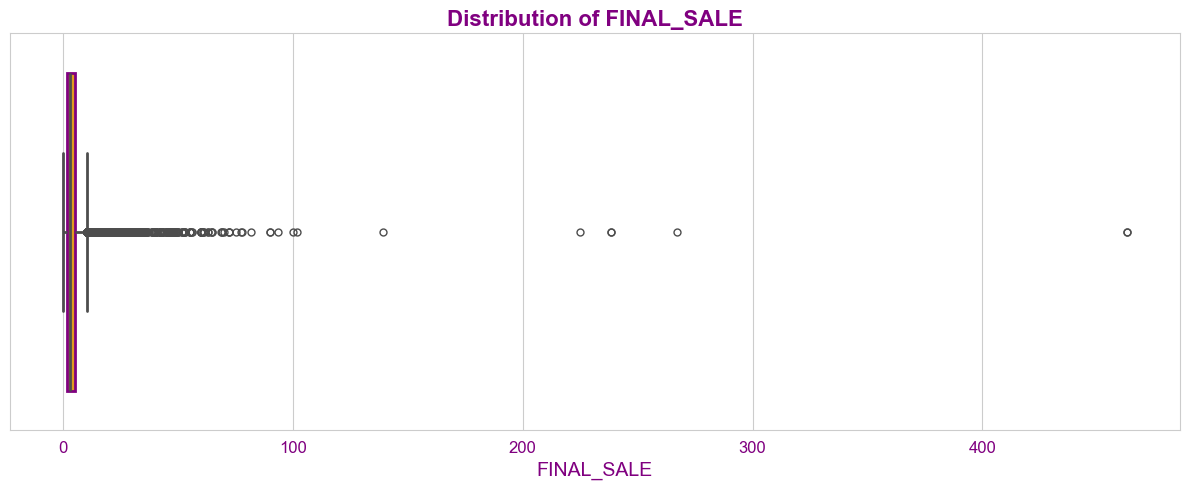

In [202]:
sns.set_style("whitegrid")

# Boxplot for FINAL_SALE
plt.figure(figsize=(12, 5))
sns.boxplot(x=transactions_df["FINAL_SALE"], color=fetch_orange, fliersize=5, linewidth=2, boxprops=dict(edgecolor=fetch_purple))
plt.title("Distribution of FINAL_SALE", fontsize=16, fontweight='bold', color=fetch_purple)
plt.xlabel("FINAL_SALE", fontsize=14, color=fetch_purple)
plt.xticks(color=fetch_purple, fontsize=12)


plt.tight_layout()
plt.show()


Check negative sales and negative quantities

In [203]:
print("Transactions with Negative Sales:", len(transactions_df[transactions_df["FINAL_SALE"] < 0]))
print("Transactions with Negative Quantities:", len(transactions_df[transactions_df["FINAL_QUANTITY"] < 0]))

Transactions with Negative Sales: 0
Transactions with Negative Quantities: 0


## Validate data range

In [204]:
print(users_df["CREATED_DATE"].dtype)  # Should be datetime64[ns]
print(users_df["BIRTH_DATE"].dtype)
print(transactions_df["PURCHASE_DATE"].dtype)
print(transactions_df["SCAN_DATE"].dtype)

datetime64[ns, UTC]
datetime64[ns, UTC]
datetime64[ns]
datetime64[ns, UTC]


The columns have time zone info, we need to convert them so that they won't cause errors

In [205]:
# Convert to datetime and remove timezone
users_df["CREATED_DATE"] = pd.to_datetime(users_df["CREATED_DATE"], errors="coerce").dt.tz_localize(None)
users_df["BIRTH_DATE"] = pd.to_datetime(users_df["BIRTH_DATE"], errors="coerce").dt.tz_localize(None)
transactions_df["PURCHASE_DATE"] = pd.to_datetime(transactions_df["PURCHASE_DATE"], errors="coerce").dt.tz_localize(None)
transactions_df["SCAN_DATE"] = pd.to_datetime(transactions_df["SCAN_DATE"], errors="coerce").dt.tz_localize(None)


In [206]:
from datetime import datetime

# Find transactions with future dates
future_transactions = transactions_df[transactions_df["PURCHASE_DATE"] > datetime.today()]
print("Transactions with Future Dates:", len(future_transactions))

# Check birth dates
users_df["AGE"] = (datetime.today() - users_df["BIRTH_DATE"]).dt.days / 365
invalid_ages = users_df[users_df["AGE"] > 120]
print("Users with Unrealistic Ages:", len(invalid_ages))

Transactions with Future Dates: 0
Users with Unrealistic Ages: 24


There are 24 users who are over 120 years old.

# Data Exploration by Visualization

In [207]:
# Use fetch company theme colors with visualizations
fetch_purple = "#800080"  # Purple
fetch_orange = "#FFA500"  # Orange

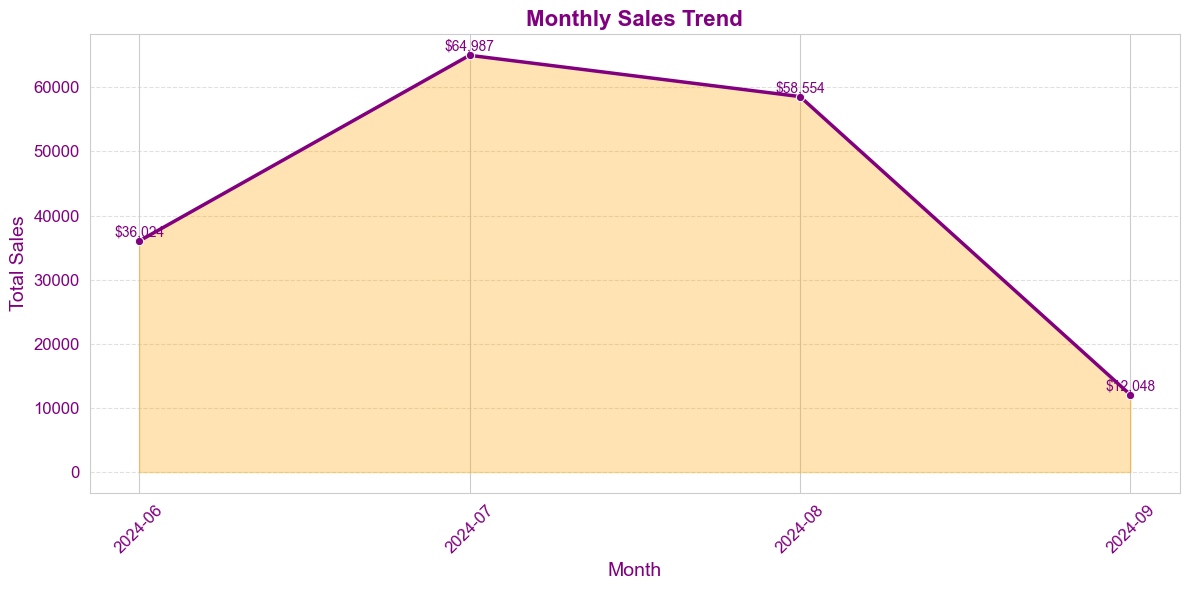

In [208]:
# Create 'month' column and group by month
transactions_df['month'] = transactions_df['PURCHASE_DATE'].dt.to_period('M').astype(str)
monthly_sales = transactions_df.groupby('month')['FINAL_SALE'].sum().reset_index()

sns.set_style("whitegrid")

# Plot Monthly Sales Trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='month', y='FINAL_SALE', marker='o', color=fetch_purple, linewidth=2.5)
plt.fill_between(monthly_sales['month'], monthly_sales['FINAL_SALE'], alpha=0.3, color=fetch_orange)
plt.title('Monthly Sales Trend', fontsize=16, fontweight='bold', color=fetch_purple)
plt.xlabel('Month', fontsize=14, color=fetch_purple)
plt.ylabel('Total Sales', fontsize=14, color=fetch_purple)
plt.xticks(rotation=45, fontsize=12, color=fetch_purple)
plt.yticks(fontsize=12, color=fetch_purple)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate data points
for i in range(len(monthly_sales)):
    plt.text(i, monthly_sales['FINAL_SALE'][i] + monthly_sales['FINAL_SALE'].max() * 0.01, f"${int(monthly_sales['FINAL_SALE'][i]):,}", ha='center', fontsize=10, color=fetch_purple)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

/var/folders/86/nc939b8d693453cchgcq630c0000gn/T/ipykernel_27928/2297412710.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_transaction_counts.index, y=state_transaction_counts.values, palette=custom_palette)


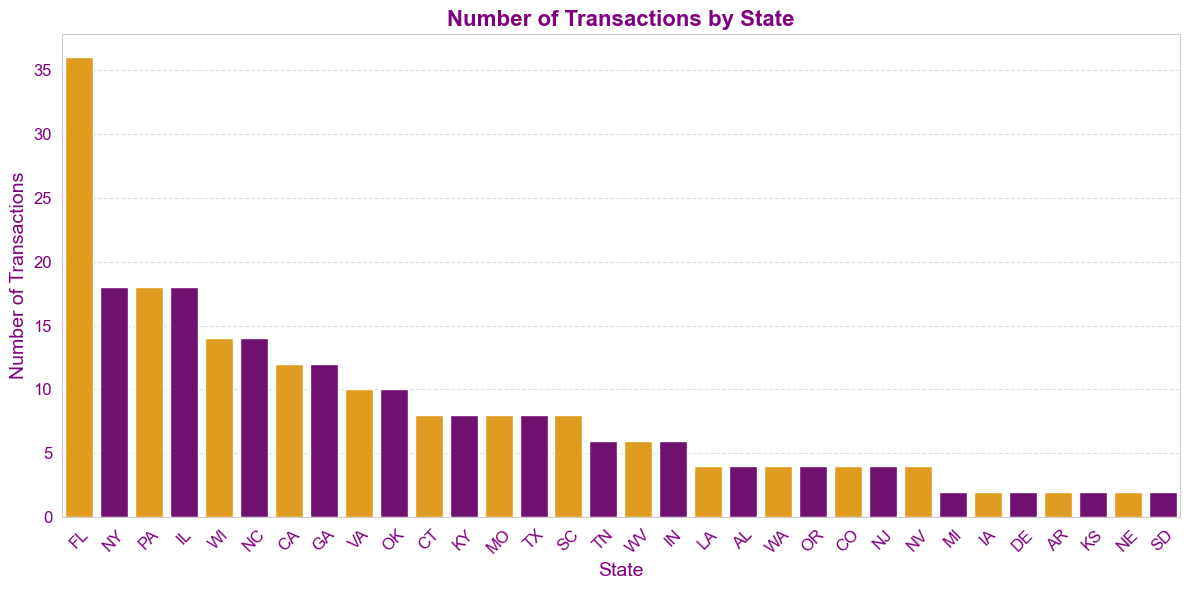

In [209]:
# Merge transactions with user data to get state information
state_transactions = transactions_df.merge(users_df, left_on='USER_ID', right_on='ID', how='left')
state_transaction_counts = state_transactions['STATE'].value_counts().sort_values(ascending=False)

# Set Seaborn style and custom color palette
sns.set_style("whitegrid")
custom_palette = sns.color_palette([fetch_orange if i % 2 == 0 else fetch_purple for i in range(len(state_transaction_counts))])

# Create bar plot with Fetch Rewards branding
plt.figure(figsize=(12, 6))
sns.barplot(x=state_transaction_counts.index, y=state_transaction_counts.values, palette=custom_palette)
plt.title('Number of Transactions by State', fontsize=16, fontweight='bold', color=fetch_purple)
plt.xlabel('State', fontsize=14, color=fetch_purple)
plt.ylabel('Number of Transactions', fontsize=14, color=fetch_purple)
plt.xticks(rotation=45, fontsize=12, color=fetch_purple)
plt.yticks(fontsize=12, color=fetch_purple)

# Add grid lines for better visual appeal
plt.grid(axis='y', linestyle='--', alpha=0.6)


# Show the plot
plt.tight_layout()
plt.show()

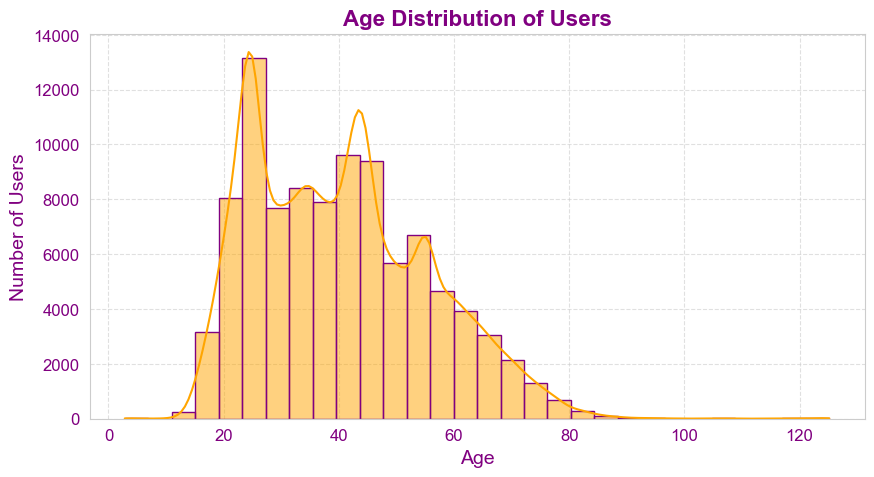

In [210]:
sns.set_style("whitegrid")
sns.set_palette([fetch_purple, fetch_orange])

# Make BIRTH_DATE is in datetime format and remove timezone info
users_df["BIRTH_DATE"] = pd.to_datetime(users_df["BIRTH_DATE"], errors="coerce").dt.tz_localize(None)

# Compute user age
users_df["AGE"] = (datetime.today() - users_df["BIRTH_DATE"]).dt.days / 365

# Plot age distribution 
plt.figure(figsize=(10, 5))
sns.histplot(users_df["AGE"], bins=30, kde=True, color=fetch_orange, edgecolor=fetch_purple)
plt.title("Age Distribution of Users", fontsize=16, fontweight='bold', color=fetch_purple)
plt.xlabel("Age", fontsize=14, color=fetch_purple)
plt.ylabel("Number of Users", fontsize=14, color=fetch_purple)

# Customize ticks
plt.xticks(fontsize=12, color=fetch_purple)
plt.yticks(fontsize=12, color=fetch_purple)

# Add grid lines for readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

/var/folders/86/nc939b8d693453cchgcq630c0000gn/T/ipykernel_27928/3832628846.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_sales.index, y=category_sales.values, palette=[fetch_orange if i % 2 == 0 else fetch_purple for i in range(len(category_sales))])


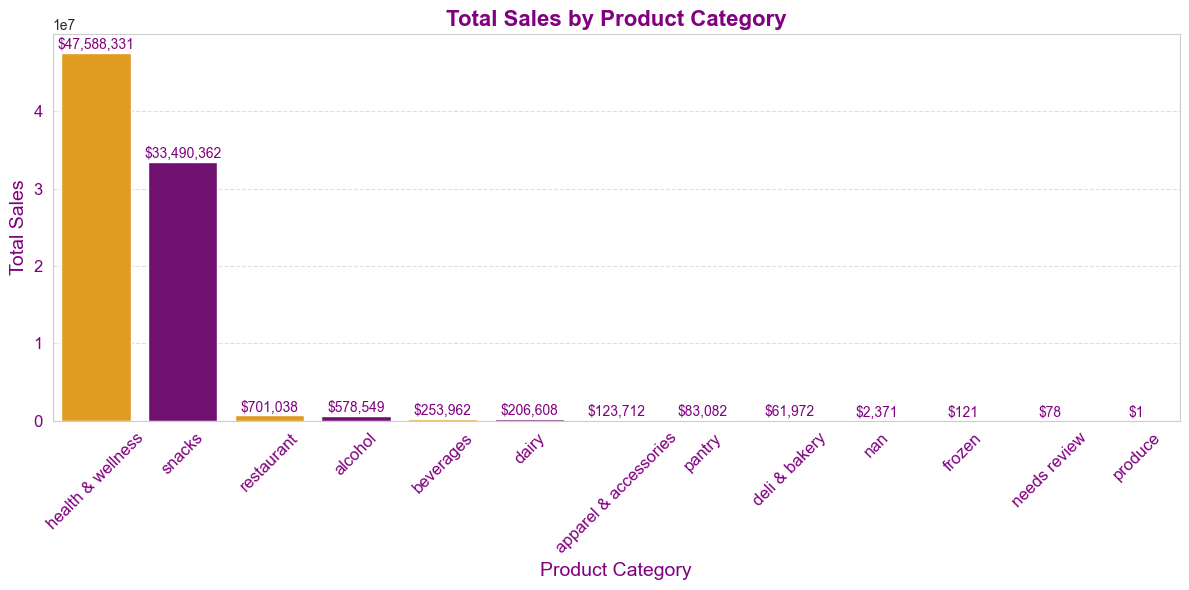

In [211]:
transactions_with_products = transactions_df.merge(products_df, on='BARCODE', how='left')

# Group by product category and sum the sales
category_sales = transactions_with_products.groupby('CATEGORY_1')['FINAL_SALE'].sum().sort_values(ascending=False)

sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x=category_sales.index, y=category_sales.values, palette=[fetch_orange if i % 2 == 0 else fetch_purple for i in range(len(category_sales))])
plt.title('Total Sales by Product Category', fontsize=16, fontweight='bold', color=fetch_purple)
plt.xlabel('Product Category', fontsize=14, color=fetch_purple)
plt.ylabel('Total Sales', fontsize=14, color=fetch_purple)
plt.xticks(rotation=45, fontsize=12, color=fetch_purple)
plt.yticks(fontsize=12, color=fetch_purple)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate bars with sales values
for index, value in enumerate(category_sales.values):
    plt.text(index, value + category_sales.max() * 0.01, f"${int(value):,}", ha='center', fontsize=10, color=fetch_purple)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

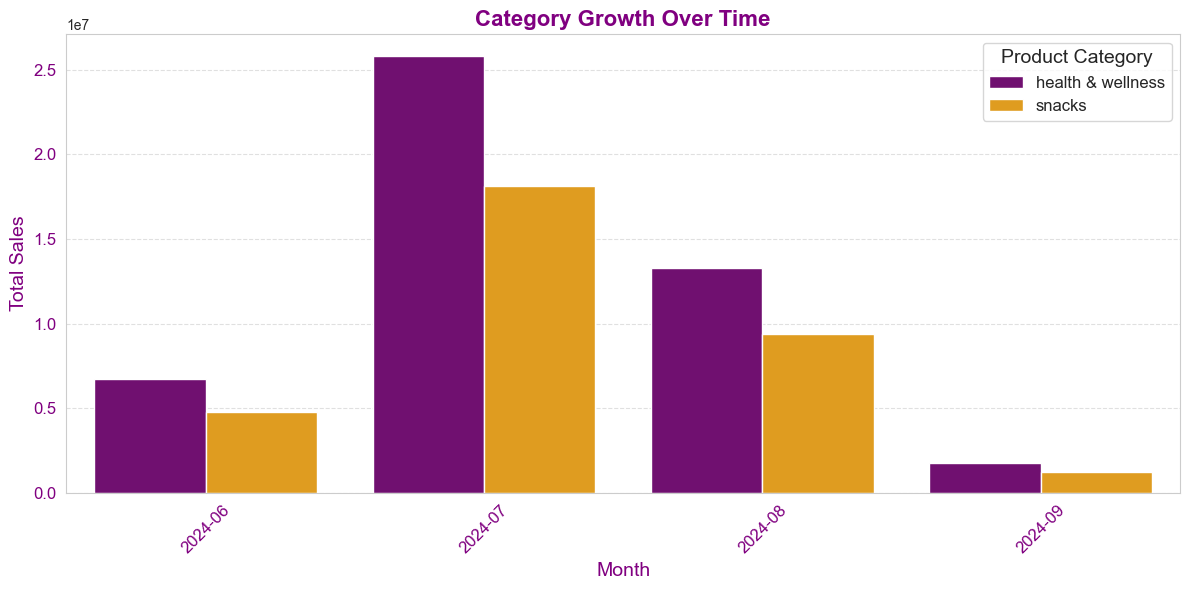

In [212]:
# Aggregate sales by category and month
transactions_with_products['month'] = pd.to_datetime(transactions_with_products['PURCHASE_DATE']).dt.to_period('M').astype(str)
category_growth = transactions_with_products.groupby(['month', 'CATEGORY_1'])['FINAL_SALE'].sum().reset_index()

# Filter for top categories
top_categories = category_growth[category_growth['CATEGORY_1'].isin(['health & wellness','snacks'])]

# Plot category growth over time
plt.figure(figsize=(12, 6))
sns.barplot(data=top_categories, x='month', y='FINAL_SALE', hue='CATEGORY_1')

# Add titles and labels
plt.title('Category Growth Over Time', fontsize=16, fontweight='bold', color="#800080")
plt.xlabel('Month', fontsize=14, color="#800080")
plt.ylabel('Total Sales', fontsize=14, color="#800080")

# Customize ticks and legend
plt.xticks(rotation=45, fontsize=12, color="#800080")
plt.yticks(fontsize=12, color="#800080")
plt.legend(title='Product Category', fontsize=12, title_fontsize=14)

# Add grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [213]:
# Calculate total spending and distinct transaction days per user
user_spending = transactions_df.groupby('USER_ID').agg(
    total_spent=pd.NamedAgg(column='FINAL_SALE', aggfunc='sum'),
    transaction_days=pd.NamedAgg(column='PURCHASE_DATE', aggfunc=lambda x: x.dt.date.nunique())
).reset_index()



In [214]:
top_20_spending_threshold = user_spending['total_spent'].quantile(0.8)
top_20_users = user_spending[(user_spending['total_spent'] >= top_20_spending_threshold)]

# Merge with user information
top_20_users_info = top_20_users.merge(users_df, left_on='USER_ID', right_on='ID', how='left')[
    ['USER_ID', 'STATE', 'LANGUAGE', 'total_spent', 'transaction_days']
]

# Sort by total spending in descending order
top_20_users_info = top_20_users_info.sort_values(by='total_spent', ascending=False)
top_20_user_revenue_per = round((top_20_users['total_spent']).sum()/transactions_df["FINAL_SALE"].sum()*100,2)
print("Percentage of revenues top 20% users generate is: ",top_20_user_revenue_per, "%")

Percentage of revenues top 20% users generate is:  55.07 %


In [215]:

# Filter out power users
power_users = user_spending[(user_spending['total_spent'] >= top_20_spending_threshold) & (user_spending['transaction_days'] >1)]

# Merge with user information
power_users_info = power_users.merge(users_df, left_on='USER_ID', right_on='ID', how='left')[
    ['USER_ID', 'STATE', 'LANGUAGE', 'total_spent', 'transaction_days']
]

# Sort by total spending in descending order
power_users_info = power_users_info.sort_values(by='total_spent', ascending=False)
power_users_per = round((len(power_users_info)/len(users_df)*100),2)
power_user_revenue_per = round((power_users['total_spent']).sum()/transactions_df["FINAL_SALE"].sum()*100,2)
print("Percentage of power users is: ", power_users_per, "%")
print("Percentage of revenues power users generate is: ",power_user_revenue_per, "%")

Percentage of power users is:  2.08 %
Percentage of revenues power users generate is:  32.35 %


In [216]:
power_users

,USER_ID,total_spent,transaction_days
5,5751fbefe4b008fae9acab39,20.93,4
10,57af9582e4b06f40aeef6f63,15.28,2
14,5880326ce4b0e8710935ed3a,83.57,3
19,58b9d9a1e4b0aa472bf7ecb3,28.87,2
33,58bd684be4b0883d67f336d5,15.92,3
...,...,...,...
17650,66816cb886cc41b000ce2336,24.48,2
17671,6682b24786cc41b000ce5e77,17.3,2
17674,6682c354465f309038ae1703,18.74,2
17681,6682cbf6465f309038ae1888,37.47,6


/var/folders/86/nc939b8d693453cchgcq630c0000gn/T/ipykernel_27928/3305371995.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.index, y=top_states.values, palette=custom_palette)
/var/folders/86/nc939b8d693453cchgcq630c0000gn/T/ipykernel_27928/3305371995.py:6: UserWarning: The palette list has more values (32) than needed (10), which may not be intended.
  sns.barplot(x=top_states.index, y=top_states.values, palette=custom_palette)


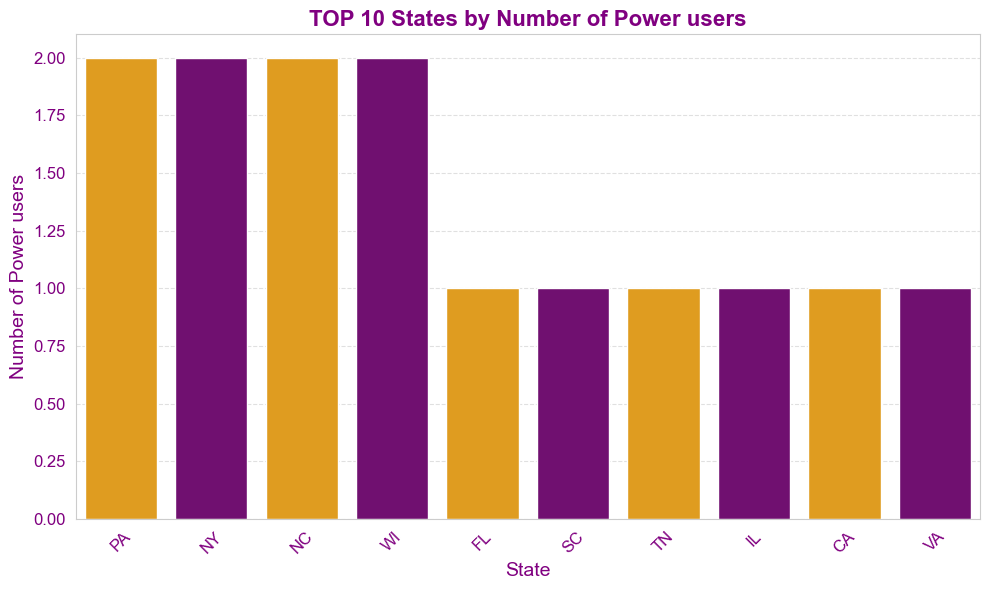

In [217]:
sns.set_style("whitegrid")
custom_palette = sns.color_palette([fetch_orange if i % 2 == 0 else fetch_purple for i in range(len(state_transaction_counts))])

top_states = power_users_info['STATE'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_states.index, y=top_states.values, palette=custom_palette)
plt.title('TOP 10 States by Number of Power users', fontsize=16, fontweight='bold', color=fetch_purple)
plt.xlabel('State', fontsize=14, color=fetch_purple)
plt.ylabel('Number of Power users', fontsize=14, color=fetch_purple)
plt.xticks(rotation=45, fontsize=12, color=fetch_purple)
plt.yticks(fontsize=12, color=fetch_purple)

# Add grid lines for better visual appeal
plt.grid(axis='y', linestyle='--', alpha=0.6)


# Show the plot
plt.tight_layout()
plt.show()


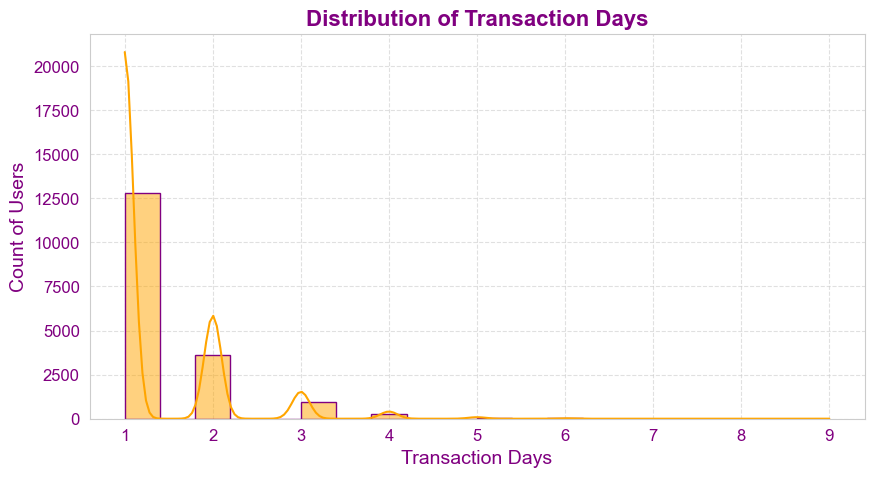

In [218]:
sns.set_style("whitegrid")
sns.set_palette([fetch_purple, fetch_orange])

# Create the histogram, titles and labels with custom fonts
plt.figure(figsize=(10, 5))
sns.histplot(x=user_spending['transaction_days'], color=fetch_orange, bins=20, kde=True, edgecolor=fetch_purple)
plt.title('Distribution of Transaction Days', fontsize=16, fontweight='bold', color=fetch_purple)
plt.xlabel('Transaction Days', fontsize=14, color=fetch_purple)
plt.ylabel('Count of Users', fontsize=14, color=fetch_purple)

# Customize tick parameters
plt.xticks(fontsize=12, color=fetch_purple)
plt.yticks(fontsize=12, color=fetch_purple)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


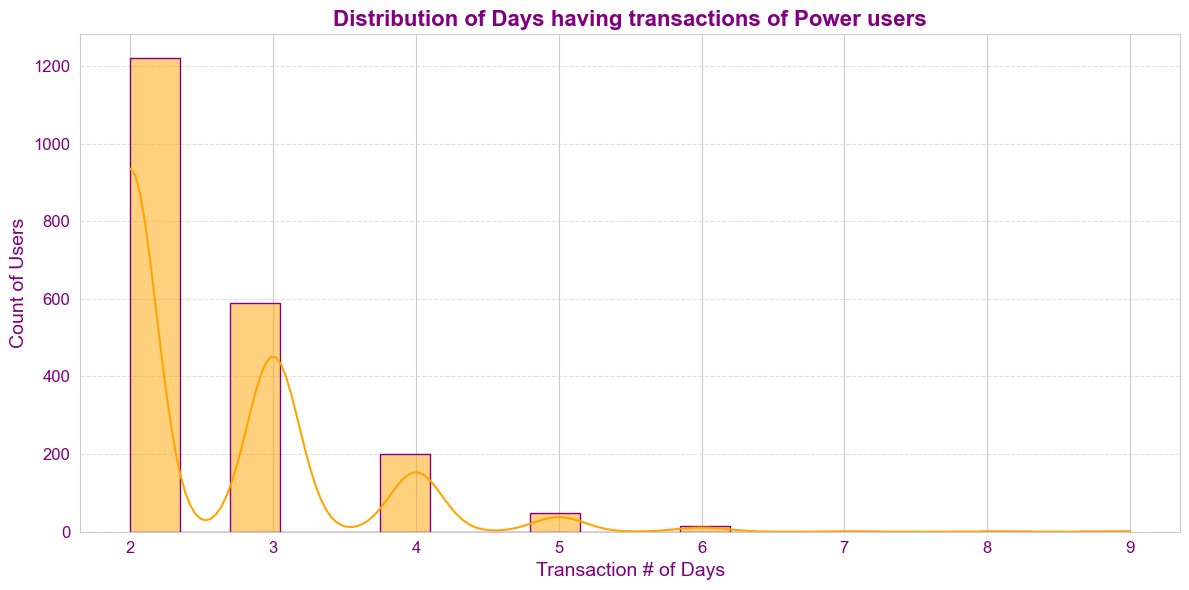

In [219]:
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(power_users['transaction_days'], bins=20, kde=True, color=fetch_orange, edgecolor=fetch_purple)

plt.title('Distribution of Days having transactions of Power users', fontsize=16, fontweight='bold', color=fetch_purple)
plt.xlabel('Transaction # of Days', fontsize=14, color=fetch_purple)
plt.ylabel('Count of Users', fontsize=14, color=fetch_purple)
plt.xticks(fontsize=12, color=fetch_purple)
plt.yticks(fontsize=12, color=fetch_purple)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()